In [1]:
!pip install datasets transformers sentencepiece --quiet

     |████████████████████████████████| 451 kB 4.8 MB/s 
     |████████████████████████████████| 5.8 MB 46.1 MB/s 
     |████████████████████████████████| 1.3 MB 60.9 MB/s 
     |████████████████████████████████| 182 kB 54.0 MB/s 
     |████████████████████████████████| 212 kB 59.9 MB/s 
     |████████████████████████████████| 132 kB 58.8 MB/s 
     |████████████████████████████████| 127 kB 59.9 MB/s 
     |████████████████████████████████| 7.6 MB 44.0 MB/s 


In [2]:
import os 
import torch 
import numpy as np
import pandas as pd

from pathlib import Path 
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from transformers import TrainingArguments, Trainer, DataCollator
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split

In [3]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
# df = pd.read_csv('/content/data (2).csv')

In [5]:
# df.head()

In [6]:
# df['Title'].isnull().sum()

In [7]:
# rows_with_nan = []
# for index, row in df.iterrows():
#     is_nan_series = row.isnull()
#     if is_nan_series.any():
#         rows_with_nan.append(index)

In [8]:
# df.info()

In [9]:
# df.drop(rows_with_nan, inplace=True)

In [10]:
# df.info()

In [11]:
# df.to_csv('dataset.csv')

In [12]:
# df = pd.read_csv('/content/drive/MyDrive/nlp/dataset.csv')

In [13]:
# df.info()

In [14]:
# df.drop('Unnamed: 0', axis = 1, inplace = True)

In [15]:
# df=df.drop_duplicates(subset = ['Title', 'Article'], keep='first')

In [16]:
# df.info()

In [17]:
# train, test = train_test_split(df, test_size=0.025)

In [18]:
# train.to_csv('/content/drive/MyDrive/nlp/train.csv')
# test.to_csv('/content/drive/MyDrive/nlp/test.csv')

In [19]:
dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/nlp/train.csv',
                                              'test': '/content/drive/MyDrive/nlp/test.csv'})
dataset = dataset.remove_columns(["Unnamed: 0","Article"])

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-eecf6ea843db6601/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['keywords', 'Title'],
        num_rows: 4623
    })
    test: Dataset({
        features: ['keywords', 'Title'],
        num_rows: 119
    })
})

In [21]:
from transformers import AutoModelWithLMHead, AutoTokenizer, set_seed
set_seed(42)
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-common_gen")
tokenizer.pad_token = tokenizer.eos_token

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

In [22]:
padding = True
def tokenize_function(examples):
    return tokenizer(examples["keywords"], max_length=64,
            return_attention_mask=True,
            add_special_tokens=True,
            truncation=True,
            padding="max_length" if padding else False,
            pad_to_max_length=padding,
            return_tensors="pt")


tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("input_ids", "input_id")
tokenized_dataset = tokenized_dataset.rename_column("attention_mask", "attention_")
tokenized_dataset

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['keywords', 'Title', 'input_id', 'attention_'],
        num_rows: 4623
    })
    test: Dataset({
        features: ['keywords', 'Title', 'input_id', 'attention_'],
        num_rows: 119
    })
})

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["Title"], max_length=128,
            return_attention_mask=True,
            add_special_tokens=True,
            truncation=True,
            padding="max_length" if padding else False,
            pad_to_max_length=padding,
            return_tensors="pt")
    
tokenized_datasets = tokenized_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("input_ids", "decoder_input_ids")
tokenized_datasets = tokenized_datasets.rename_column("attention_mask", "decoder_attention_mask")
tokenized_datasets = tokenized_datasets.rename_column("input_id", "input_ids")
tokenized_datasets = tokenized_datasets.rename_column("attention_", "attention_mask")
tokenized_datasets = tokenized_datasets.remove_columns(["keywords","Title"])
columns = ['input_ids', 'decoder_input_ids', 'attention_mask', 'decoder_attention_mask']
tokenized_datasets.set_format(type='torch', columns=columns)

tokenized_datasets

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'],
        num_rows: 4623
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'],
        num_rows: 119
    })
})

In [24]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [25]:
# training_args.num_train_epochs = 15
# training_args.per_device_train_batch_size=1

In [26]:
tokenized_datasets['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'],
    num_rows: 4623
})

In [27]:
torch.cuda.empty_cache()

In [28]:
from torch.utils.data import DataLoader
t_datasets = tokenized_datasets.flatten()
train_dataloader = DataLoader(t_datasets['train'], shuffle=True, batch_size=2)
eval_dataloader = DataLoader(t_datasets['test'], batch_size=2)

In [29]:
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-common_gen")
model.config.pad_token_id = model.config.eos_token_id

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

In [30]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [31]:
from transformers import get_scheduler

num_epochs = 15
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [33]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [34]:
val_loss = []
def evaluate(model, eval_dataloader):
  model.eval()
  with torch.no_grad():
      e_loss = 0.0
  for batch in eval_dataloader:
        y = batch["decoder_input_ids"].to(device, dtype=torch.long)
        lm_labels = y[:, :].clone()
        lm_labels[y[:, :] == tokenizer.pad_token_id] = -100
        ids = batch["input_ids"].to(device, dtype=torch.long)
        mask = batch["attention_mask"].to(device, dtype=torch.long)
        outputs = model(input_ids=ids,
                        attention_mask=mask,
                        labels=lm_labels)
        loss = outputs[0]
        e_loss += (loss.cpu().detach())
  val_loss.append(e_loss/len(eval_dataloader))

In [35]:
from tqdm.auto import tqdm
train_loss = []
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs): 
    t_loss = 0.0
    for batch in train_dataloader:
        y = batch["decoder_input_ids"].to(device, dtype=torch.long)
        lm_labels = y[:, :].clone()
        lm_labels[y[:, :] == tokenizer.pad_token_id] = -100
        ids = batch["input_ids"].to(device, dtype=torch.long)
        mask = batch["attention_mask"].to(device, dtype=torch.long)
        outputs = model(input_ids=ids,
                        attention_mask=mask,
                        labels=lm_labels)
        
        loss = outputs[0]
        t_loss += (loss.cpu().detach())
        
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_loss.append(t_loss/len(train_dataloader))
    evaluate(model, eval_dataloader)

  0%|          | 0/34680 [00:00<?, ?it/s]

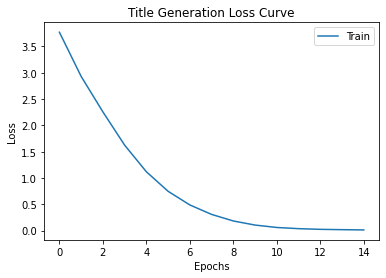

In [38]:
import matplotlib.pyplot as plt
import numpy as np
y = np.arange(0, num_epochs)
plt.title("Title Generation Loss Curve")
plt.plot(y, train_loss, label="Train")
#plt.plot(y, val_loss, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
sentences = ["rock host netflix", "best t20 innings", "destination hip hop"]

inputs = tokenizer([sentence for sentence in sentences], return_tensors="pt", padding=True)

output_sequences = model.generate(
    input_ids=inputs["input_ids"].to(device, dtype=torch.long),
    attention_mask=inputs["attention_mask"].to(device, dtype=torch.long),
    do_sample=False,  # disable sampling to test if batching affects output
)

print(tokenizer.batch_decode(output_sequences, skip_special_tokens=True))

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['Rock to host Netflix’s first live broadcast in four years, starting with $5 million CAD', 'Best T20 innings of the year so far: Manisha Virbata and Man', 'Destination Hip-Hop Meets New New York City Millennials - a']


In [ ]:
modelsavename= "/content/title_generation.pt"  # change the name here to save in a specific file (and restore below)
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

In [ ]:
from transformers import AutoConfig, AutoModelWithLMHead, AutoTokenizer
MODEL_PATH = '/content/drive/MyDrive/nlp/title_generation_2.pt'
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-common_gen")
tokenizer.pad_token = tokenizer.eos_token
config = AutoConfig.from_pretrained("mrm8488/t5-base-finetuned-common_gen")
model = AutoModelWithLMHead.from_pretrained(MODEL_PATH, config = config)
model.to(device)
model.tie_weights()
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
sentences = ["Rock host netflix", "best t20 innings", "destination hip hop"]
MAX_LEN = 20
inputs = tokenizer([sentence for sentence in sentences], return_tensors="pt", padding=True)

output_sequences = model.generate(
    input_ids=inputs["input_ids"].to(device, dtype=torch.long),
    attention_mask=inputs["attention_mask"].to(device, dtype=torch.long),
    do_sample=True,
    max_length = MAX_LEN,
)

print(tokenizer.batch_decode(output_sequences, skip_special_tokens=True))

['Nicky Lee Hales: Will Rock host Netflix? Heard of him today on HG', 'Nadine Kerr gets best of his T20 innings with a solo century in India', 'YG returns to Aspen as a premium destination for hip hop fans: Yak']
